# Logit Lens and Direct Logit Attribution

In this notebook, we will apply direct logit attribution to our maze-transformer model. 

This is mostly just getting the data in an appropriate format and using techniques from Neel's explanatory analysis.

## Setup

In [106]:
# Generic
import os
from pathlib import Path
from copy import deepcopy
import typing

# Numerical Computing
import numpy as np
import torch
import pandas as pd
# import torch.nn.functional as F
from fancy_einsum import einsum
import einops
from jaxtyping import Float, Int, Bool
import matplotlib.pyplot as plt

from muutils.misc import shorten_numerical_to_str
from muutils.nbutils.configure_notebook import configure_notebook
# TransformerLens imports
from transformer_lens import ActivationCache

# Our Code
from maze_dataset import MazeDataset, MazeDatasetConfig, SolvedMaze, LatticeMaze, SPECIAL_TOKENS
from maze_dataset.tokenization import MazeTokenizer, TokenizationMode
from maze_dataset.plotting.print_tokens import color_maze_tokens_AOTP

# from maze_transformer.tokenizer import HuggingMazeTokenizer
from maze_transformer.training.config import ConfigHolder, ZanjHookedTransformer, BaseGPTConfig
from maze_transformer.evaluation.eval_model import  load_model_with_configs
from maze_transformer.mechinterp.plot_logits import plot_logits

In [2]:
# Setup (we won't be training any models)
DEVICE: torch.device = configure_notebook(seed=42, dark_mode=True)
print(f"{DEVICE = }")
torch.set_grad_enabled(False)

DEVICE = device(type='cpu')


## Loading the model in

Loading in Alex's successfully trained model, it uses an embedding dimension of 384 with 6 heads and 12 layers

In [3]:
MODEL: ZanjHookedTransformer = ZanjHookedTransformer.read("../examples/hallway-medium_2023-06-16-03-40-47.iter_26554.zanj")
num_params: int = MODEL.num_params()
print(f"loaded model with {shorten_numerical_to_str(num_params)} params ({num_params = })")
GPT_CONFIG: BaseGPTConfig = MODEL.zanj_model_config.model_cfg
TOKENIZER: MazeTokenizer = MODEL.zanj_model_config.maze_tokenizer

loaded model with 1.3M params (num_params = 1274699)


## Dataset Creation

Creating a collection of mazes to have the model predict on

In [4]:
# get 100 mazes and pass into model, storing logits and cache
n_examples: int = 100
TEST_DATASET_CFG: MazeDatasetConfig = deepcopy(MODEL.zanj_model_config.dataset_cfg)
TEST_DATASET_CFG.n_mazes = n_examples
# hacky: adjust things to work
for filter in TEST_DATASET_CFG.applied_filters:
	if len(filter["args"]) == 0:
		filter["args"] = tuple()

DATASET: MazeDataset = MazeDataset.from_config(TEST_DATASET_CFG)
DATASET_TOKENS: list[list[str]] = DATASET.as_tokens(TOKENIZER, join_tokens_individual_maze=False)

print(f"loaded {len(DATASET_TOKENS)} mazes")
print(f"first maze:\n{' '.join(DATASET_TOKENS[0])}")
print(f"first maze, colored:\n{color_maze_tokens_AOTP(DATASET_TOKENS[0], fmt='terminal')}")

loaded 100 mazes
first maze:
<ADJLIST_START> (6,4) <--> (6,3) ; (4,7) <--> (3,7) ; (3,4) <--> (3,5) ; (3,3) <--> (4,3) ; (4,4) <--> (4,5) ; (3,7) <--> (3,6) ; (3,3) <--> (3,4) ; (4,7) <--> (4,6) ; (4,2) <--> (4,1) ; (6,5) <--> (5,5) ; (3,5) <--> (3,6) ; (4,6) <--> (4,5) ; (5,1) <--> (4,1) ; (6,4) <--> (6,5) ; (5,1) <--> (5,2) ; (5,2) <--> (5,3) ; (5,3) <--> (5,4) ; (4,3) <--> (4,2) ; (5,4) <--> (5,5) ; <ADJLIST_END> <ORIGIN_START> (3,4) <ORIGIN_END> <TARGET_START> (4,1) <TARGET_END> <PATH_START> (3,4) (3,3) (4,3) (4,2) (4,1) <PATH_END>
first maze, colored:
<ADJLIST_START> (6,4) <--> (6,3) ; (4,7) <--> (3,7) ; (3,4) <--> (3,5) ; (3,3) <--> (4,3) ; (4,4) <--> (4,5) ; (3,7) <--> (3,6) ; (3,3) <--> (3,4) ; (4,7) <--> (4,6) ; (4,2) <--> (4,1) ; (6,5) <--> (5,5) ; (3,5) <--> (3,6) ; (4,6) <--> (4,5) ; (5,1) <--> (4,1) ; (6,4) <--> (6,5) ; (5,1) <--> (5,2) ; (5,2) <--> (5,3) ; (5,3) <--> (5,4) ; (4,3) <--> (4,2) ; (5,4) <--> (5,5) ; <ADJLIST_END> <ORIGIN_START> (3,4) <ORIGIN_END> <TARGET_STAR

get the data up to the path start token, as well as the path start tokens themselves

In [5]:
# get_token_first_index: typing.Callable[[str, list[str]], int] = lambda search_token, token_list: token_list.index(search_token)
def get_token_first_index(search_token: str, token_list: list[str]) -> int:
	return token_list.index(search_token)

TaskSetup = typing.NamedTuple("TaskSetup", [
	("prompts", list[list[str]]),
	("targets", str),
])

class DLAProtocol(typing.Protocol):
	"""should take a dataset, and return a tuple of (prompts, targets)"""
	def __call__(self, dataset_tokens: list[list[str]], **kwargs) -> TaskSetup:
		...


def setup_task_starttoken(
	dataset_tokens: list[list[str]], 
	start_token: str,
) -> TaskSetup:

	prompts: list[list[str]] = list()
	targets: list[str] = list()

	for maze_tokens in DATASET_TOKENS:
		path_start_idx: int = get_token_first_index(SPECIAL_TOKENS.PATH_START, maze_tokens)
		prompt_tokens: list[str] = maze_tokens[:path_start_idx + 1]
		prompts.append(prompt_tokens)
		targets.append(maze_tokens[path_start_idx + 1])

	return TaskSetup(prompts=prompts, targets=targets)


In [6]:
DATASET_PROMPTS: list[list[str]]
DATASET_PROMPTS_JOINED: list[str]
DATASET_TARGETS: list[str]
DATASET_TARGET_IDS: Float[torch.Tensor, "n_mazes"]

DATASET_PROMPTS, DATASET_TARGETS = setup_task_starttoken(DATASET_TOKENS, SPECIAL_TOKENS.PATH_START)
DATASET_PROMPTS_JOINED = [" ".join(prompt) for prompt in DATASET_PROMPTS]
DATASET_TARGET_IDS = torch.tensor(TOKENIZER.encode(DATASET_TARGETS), dtype=torch.long)

print(f"first maze prompt:\n{'[...] ' + DATASET_PROMPTS_JOINED[0][-150:]}")
print(f"first maze target:\n{DATASET_TARGETS[0]}")
print(f"first maze target id:\n{DATASET_TARGET_IDS[0]}")

n_mazes: int = len(DATASET_TOKENS)
d_vocab: int = TOKENIZER.vocab_size

first maze prompt:
[...] 5,3) <--> (5,4) ; (4,3) <--> (4,2) ; (5,4) <--> (5,5) ; <ADJLIST_END> <ORIGIN_START> (3,4) <ORIGIN_END> <TARGET_START> (4,1) <TARGET_END> <PATH_START>
first maze target:
(3,4)
first maze target id:
33


# run model

In [7]:
LOGITS: Float[torch.Tensor, "n_mazes seq_len d_vocab"]
CACHE: ActivationCache

LOGITS, CACHE = MODEL.run_with_cache(DATASET_PROMPTS_JOINED)

In [8]:
print(f"{n_mazes = }, {d_vocab = }")
print(f"{LOGITS.shape = }")
cache_shapes: dict[str, tuple[int, ...]] = {k: v.shape for k, v in CACHE.items()}
print(f"{cache_shapes = }")

n_mazes = 100, d_vocab = 75
LOGITS.shape = torch.Size([100, 238, 75])
cache_shapes = {'hook_embed': torch.Size([100, 238, 128]), 'hook_pos_embed': torch.Size([100, 238, 128]), 'blocks.0.hook_resid_pre': torch.Size([100, 238, 128]), 'blocks.0.ln1.hook_scale': torch.Size([100, 238, 1]), 'blocks.0.ln1.hook_normalized': torch.Size([100, 238, 128]), 'blocks.0.attn.hook_q': torch.Size([100, 238, 4, 32]), 'blocks.0.attn.hook_k': torch.Size([100, 238, 4, 32]), 'blocks.0.attn.hook_v': torch.Size([100, 238, 4, 32]), 'blocks.0.attn.hook_attn_scores': torch.Size([100, 4, 238, 238]), 'blocks.0.attn.hook_pattern': torch.Size([100, 4, 238, 238]), 'blocks.0.attn.hook_z': torch.Size([100, 238, 4, 32]), 'blocks.0.hook_attn_out': torch.Size([100, 238, 128]), 'blocks.0.hook_resid_mid': torch.Size([100, 238, 128]), 'blocks.0.ln2.hook_scale': torch.Size([100, 238, 1]), 'blocks.0.ln2.hook_normalized': torch.Size([100, 238, 128]), 'blocks.0.mlp.hook_pre': torch.Size([100, 238, 512]), 'blocks.0.mlp.hook_post':

we expect the logits to have shape `(n_mazes, n_tokens, n_vocab)`


## get and evaluate predictions

these should have shape `(n_mazes, n_vocab)`

In [9]:
LAST_TOK_LOGITS: Float[torch.Tensor, "n_mazes d_vocab"] = LOGITS[:, -1, :]
print(f"{LAST_TOK_LOGITS.shape = }")

LAST_TOK_LOGITS.shape = torch.Size([100, 75])


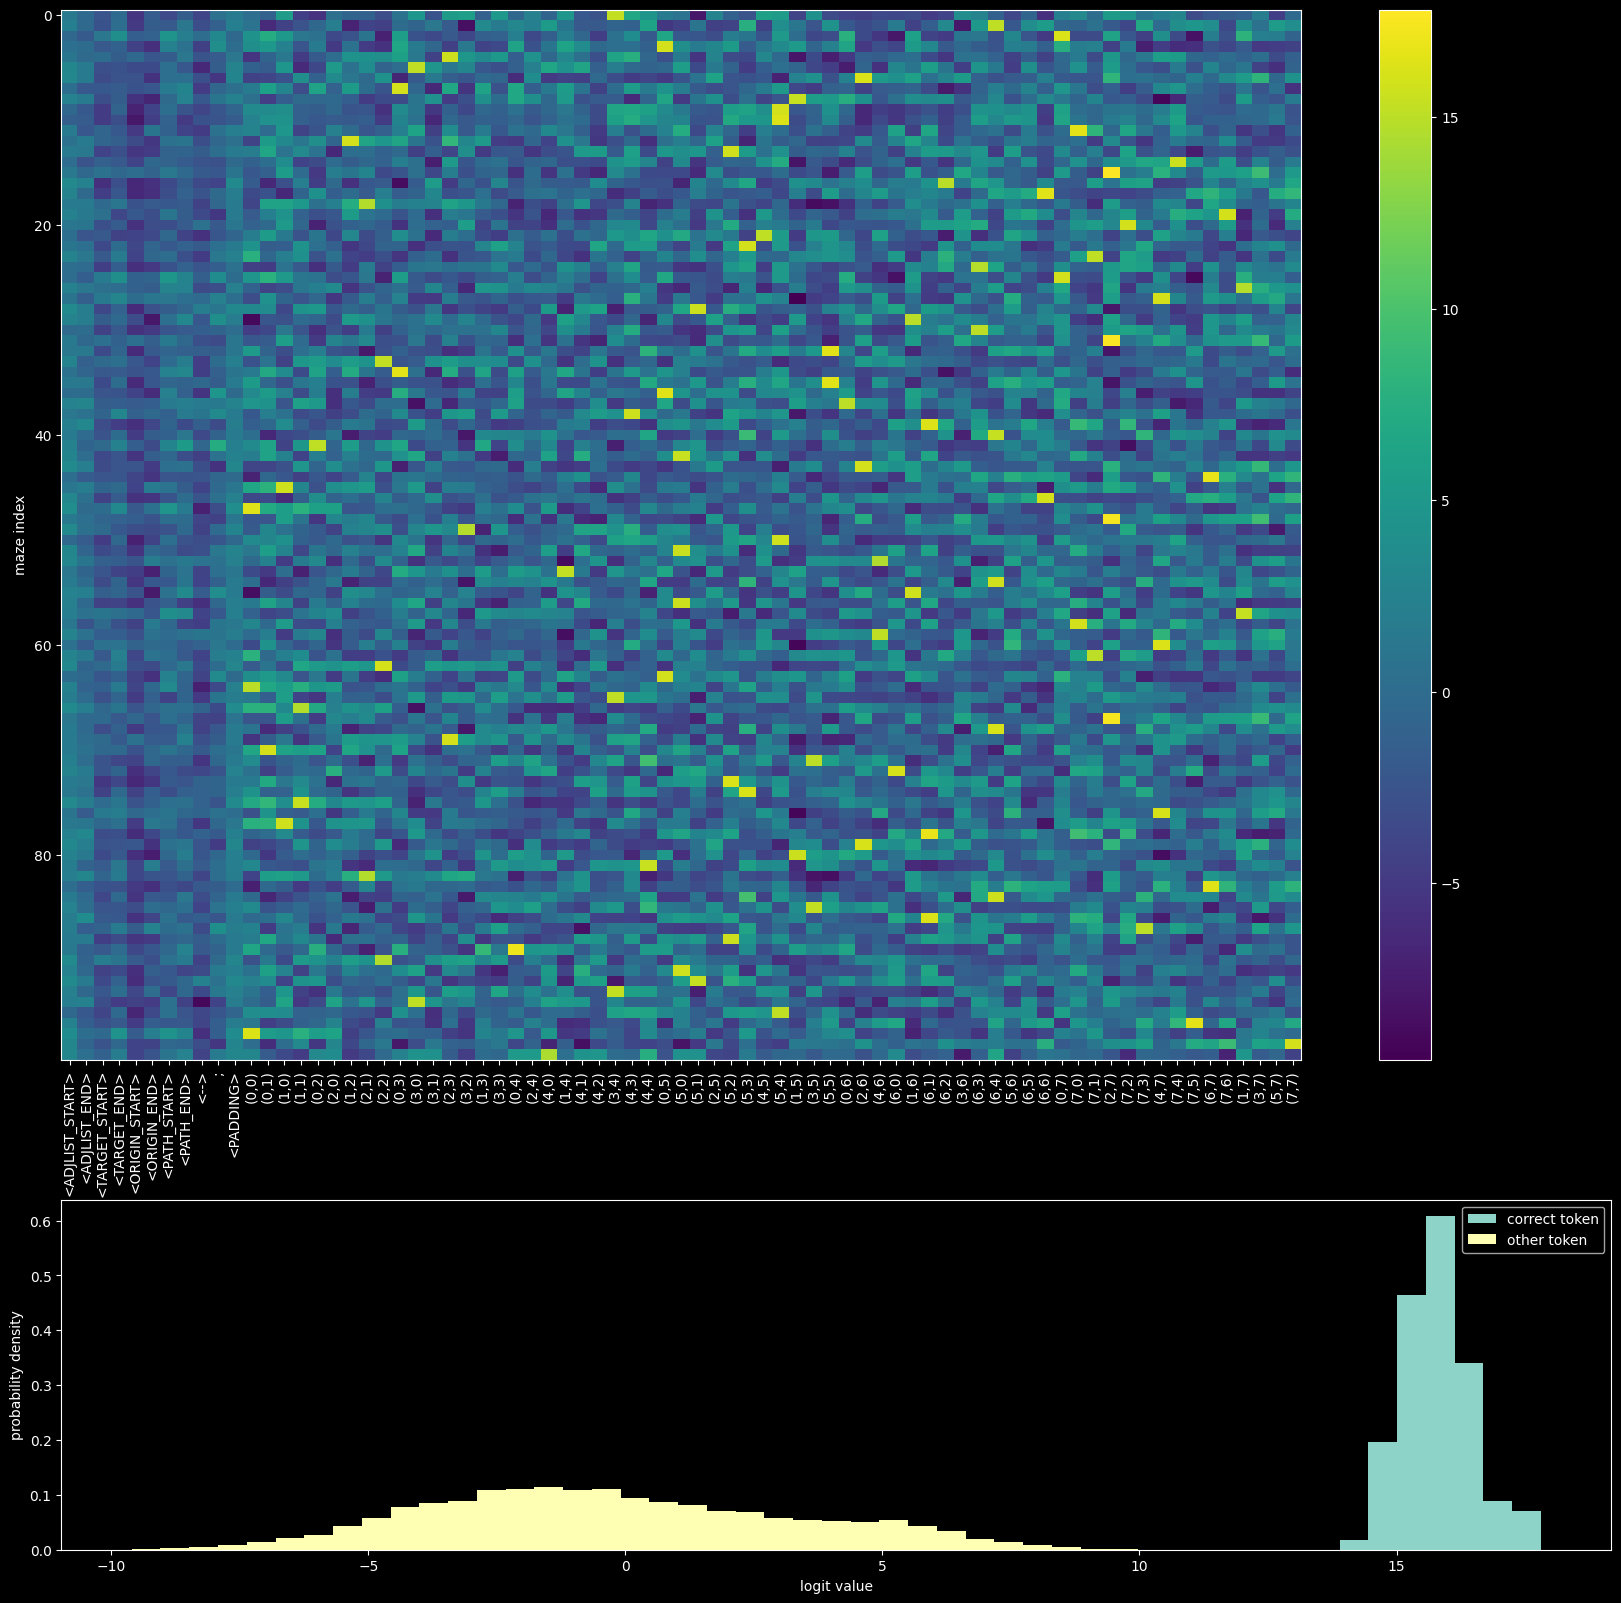

(<Figure size 2000x2000 with 3 Axes>,
 (<Axes: xlabel='vocab element logit', ylabel='maze index'>,
  <Axes: xlabel='logit value', ylabel='probability density'>))

In [10]:
plot_logits(
    last_tok_logits=LAST_TOK_LOGITS,
    target_idxs=DATASET_TARGET_IDS,
    tokenizer=TOKENIZER,
    n_bins=50,
)

In [11]:
PREDICTED_TOKENS: list[str] = TOKENIZER.decode(LAST_TOK_LOGITS.argmax(dim=-1).tolist())
print(f"{len(PREDICTED_TOKENS) = }")
print(f"{DATASET_TARGETS[0] = }")
print(f"{PREDICTED_TOKENS[0] = }")

len(PREDICTED_TOKENS) = 100
DATASET_TARGETS[0] = '(3,4)'
PREDICTED_TOKENS[0] = '(3,4)'


In [12]:
prediction_correct: Bool[torch.Tensor, "n_mazes"] = torch.tensor([
	pred == target 
	for pred, target in zip(PREDICTED_TOKENS, DATASET_TARGETS)
])

print(f"{prediction_correct.shape = }")
print(f"{prediction_correct.float().mean().item() = }")

prediction_correct.shape = torch.Size([100])
prediction_correct.float().mean().item() = 1.0


## directions in residual stream

In [100]:
def logits_to_avg_logit_diff(
        final_logits: Float[torch.Tensor, "n_mazes d_vocab"],
        answer_tokens: Int[torch.Tensor, "n_mazes"],
        compare_to: Int[torch.Tensor, "n_mazes"]|None = None,
        per_prompt: bool = True,
    ) -> Float[torch.Tensor, "n_mazes"]|float:
    """From Neels explanatory notebook
    
    https://colab.research.google.com/github/neelnanda-io/Easy-Transformer/blob/main/Exploratory_Analysis_Demo.ipynb
    """
    LArr = Float[torch.Tensor, "n_mazes"]

    # logit on the answer token for each sample
    answer_logits: LArr = torch.gather(final_logits, 1, answer_tokens.unsqueeze(1)).squeeze(1)
 
    output: LArr
    if compare_to is None:
        # logits of all tokens for each sample
        all_logits: LArr = torch.sum(final_logits, dim=1)
        output = answer_logits - (all_logits - answer_logits)
    else:
        # specifically the comparison tokens
        compare_to_logits: LArr = torch.gather(final_logits, 1, compare_to.unsqueeze(1)).squeeze(1)
        output = answer_logits - compare_to_logits

    assert output.shape == answer_tokens.shape

    if per_prompt:
        return output
    else:
        return output.mean().item()

    # return answer_logits / (all_logits - answer_logits)

In [161]:
def logit_diff_residual_stream(
	model: ZanjHookedTransformer,
	cache: ActivationCache,
	answer_tokens: Int[torch.Tensor, "n_mazes"],
	compare_to: Int[torch.Tensor, "n_mazes"]|None = None,
	directions: bool = False,
) -> float|tuple[float, torch.Tensor]:
	# embed the whole vocab first
	d_vocab: int = model.zanj_model_config.maze_tokenizer.vocab_size
	vocab_tensor: Float[torch.Tensor, "d_vocab"] = torch.arange(d_vocab, dtype=torch.long)
	vocab_residual_directions = model.tokens_to_residual_directions(vocab_tensor)
	# get embedding of answer tokens
	answer_residual_directions = vocab_residual_directions[answer_tokens]
	# get the directional difference
	logit_diff_directions: Float[torch.Tensor, "n_mazes d_model"]
	if compare_to is None:
		logit_diff_directions = answer_residual_directions - vocab_residual_directions[~answer_tokens]
	else:
		logit_diff_directions = answer_residual_directions - vocab_residual_directions[compare_to]


	# get the values from the cache at the last layer and last token
	final_token_residual_stream = cache["resid_post", -1][:, -1, :]
	# scaling the values in residual stream with layer norm
	scaled_final_token_residual_stream = cache.apply_ln_to_stack(
		final_token_residual_stream, layer = -1, pos_slice=-1,
	)


	average_logit_diff = torch.dot(
		scaled_final_token_residual_stream.flatten(),
		logit_diff_directions.flatten(),
	) / logit_diff_directions.shape[0]

	if directions:
		return average_logit_diff.item(), logit_diff_directions
	else:
		return average_logit_diff.item()



           test compare_to  result_orig  result_res       diff      ratio
0        target        all    31.570227   13.288536  18.281691   2.375749
1     predicted        all    31.570227   13.288536  18.281691   2.375749
2       sampled        all    31.570227   13.288536  18.281691   2.375749
3    noise=1.00        all    31.570227   13.288536  18.281691   2.375749
4    noise=2.00        all    31.570227   13.288536  18.281691   2.375749
5    noise=3.00        all    30.717707   12.981084  17.736623   2.366344
6    noise=5.00        all    23.296978    9.299020  13.997958   2.505315
7   noise=10.00        all    10.707747    4.629212   6.078534   2.313082
8     random_r0        all     0.813235    0.008194   0.805041  99.245188
9        target     random    15.416491   13.072321   2.344170   1.179323
10    predicted     random    15.416491   13.072321   2.344170   1.179323
11      sampled     random    15.416491   13.072321   2.344170   1.179323
12   noise=1.00     random    15.41649

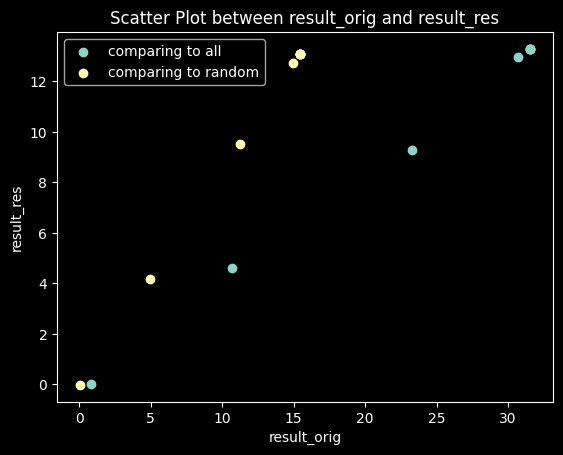

In [162]:
def logits_diff(
	model: ZanjHookedTransformer,
	cache: ActivationCache,
	dataset_target_ids: Int[torch.Tensor, "n_mazes"],
	last_tok_logits: Float[torch.Tensor, "n_mazes d_vocab"],
	noise_sigmas: list[float] = [1, 2, 3, 5, 10],
	n_randoms: int = 1,
) -> pd.DataFrame:
	
	test_logits: dict[str, Float[torch.Tensor, "n_mazes"]] = {
		"target": dataset_target_ids, 
		"predicted": last_tok_logits.argmax(dim=-1), 
		"sampled": torch.multinomial(torch.softmax(last_tok_logits, dim=-1), num_samples=1).squeeze(-1),
		**{
			f"noise={s:.2f}": (last_tok_logits + s*torch.randn_like(last_tok_logits)).argmax(dim=-1)
			for s in noise_sigmas
		},
		# "random": torch.randint_like(dataset_target_ids, low=0, high=d_vocab),
		**{
			f"random_r{i}": torch.randint_like(dataset_target_ids, low=0, high=d_vocab)
			for i in range(n_randoms)
		},
	}
	compare_dict: dict[str, None|Float[torch.Tensor, "n_mazes"]] = {
		"all": None,
		"random": torch.randint_like(dataset_target_ids, low=0, high=d_vocab),
		"target": dataset_target_ids,
	}

	outputs: list[dict] = list()

	for k_comp, compare_to in compare_dict.items():
		for k, d in test_logits.items():
			result_orig: float = logits_to_avg_logit_diff(
				final_logits=last_tok_logits, 
				answer_tokens=d,
				per_prompt=False,
				compare_to=compare_to,
			)
			result_res: float = logit_diff_residual_stream(
				model=model,
				cache=cache,
				answer_tokens=d,
				compare_to=compare_to,
			)
			# print(f"logit diff of {k}\tcompare:\t{'all' if compare_to is None else 'random'}\t{result = }\t{result_res = }")
			outputs.append(dict(
				test=k,
				compare_to=k_comp,
				result_orig=result_orig,
				result_res=result_res,
			))

	df_out: pd.DataFrame = pd.DataFrame(outputs)
	df_out["diff"] = df_out["result_orig"] - df_out["result_res"]
	df_out["ratio"] = df_out["result_orig"] / df_out["result_res"]


	return df_out

LOGIT_DIFF_DF: pd.DataFrame = logits_diff(
	model=MODEL,
	cache=CACHE,
	dataset_target_ids=DATASET_TARGET_IDS,
	last_tok_logits=LAST_TOK_LOGITS,
	# noise_sigmas=np.logspace(0, 3, 100),
)

print(LOGIT_DIFF_DF)

# scatter separately for "all" vs "random"
fig, ax = plt.subplots()
for compare_to in ["all", "random"]:
	df = LOGIT_DIFF_DF[LOGIT_DIFF_DF["compare_to"] == compare_to]
	ax.scatter(
		df['result_orig'], df['result_res'], 
		label=f"comparing to {compare_to}",
		marker='o',
	)
ax.legend()
plt.xlabel('result_orig')
plt.ylabel('result_res')
plt.title('Scatter Plot between result_orig and result_res')
plt.show()


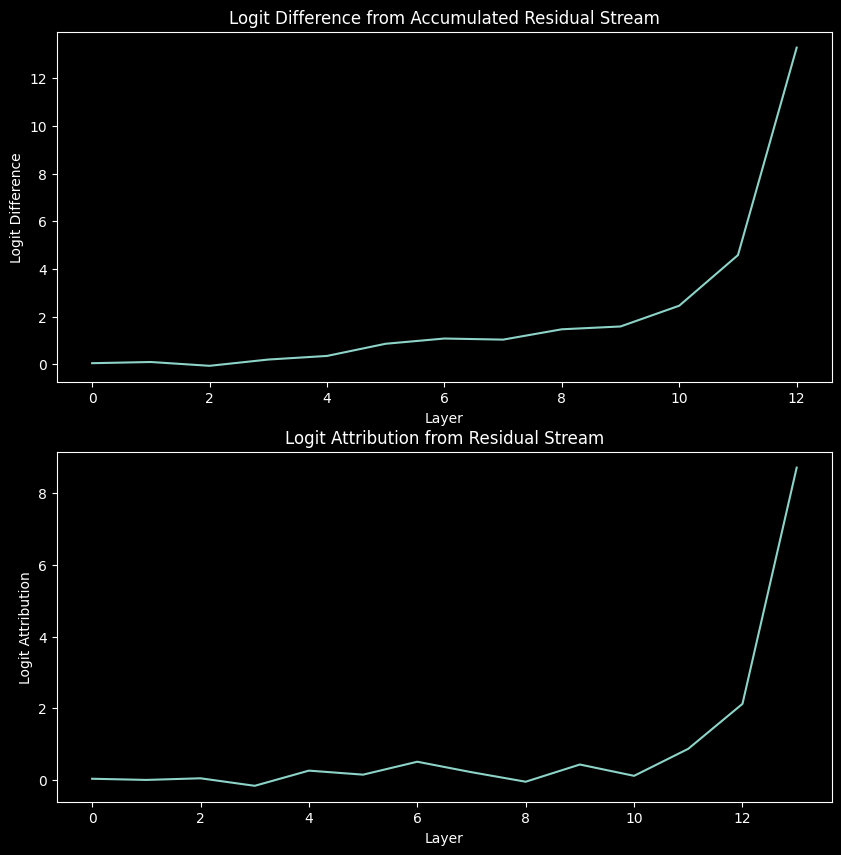

In [174]:
def residual_stack_to_logit_diff(
        residual_stack: Float[torch.Tensor, "components batch d_model"], 
        cache: ActivationCache,
        logit_diff_directions: Float[torch.Tensor, "n_mazes d_model"],
    ) -> float:

    scaled_residual_stack = cache.apply_ln_to_stack(residual_stack, layer = -1, pos_slice=-1)

    return einsum(
        "... batch d_model, batch d_model -> ...", 
        scaled_residual_stack, logit_diff_directions,
    ) / logit_diff_directions.shape[0]

def compute_logit_lens(
    model: ZanjHookedTransformer,
    cache: ActivationCache,
    answer_tokens: Int[torch.Tensor, "n_mazes"],        
) -> tuple[
    torch.Tensor, torch.Tensor, # x/y for diff
    torch.Tensor, torch.Tensor, # x/y for attr
]:
    # logit diff
    avg_diff, diff_direction = logit_diff_residual_stream(
        model=model,
        cache=cache,
        answer_tokens=answer_tokens,
        compare_to=None,
        directions=True,
    )

    accumulated_residual, labels = cache.accumulated_resid(
        layer=-1, incl_mid=True, pos_slice=-1, return_labels=True,
    )

    logit_lens_logit_diffs = residual_stack_to_logit_diff(
        residual_stack=accumulated_residual,
        cache=cache,
        logit_diff_directions=diff_direction,
    )

    # logit attribution
    per_layer_residual, labels = cache.decompose_resid(layer=-1, pos_slice=-1, return_labels=True)
    per_layer_logit_diffs = residual_stack_to_logit_diff(
        residual_stack=per_layer_residual,
        cache=cache,
        logit_diff_directions=diff_direction,
    )

    return (
        # np.arange(model.zanj_model_config.model_cfg.n_layers*2+1)/2,
        np.arange(logit_lens_logit_diffs.shape[0]),
        logit_lens_logit_diffs.to("cpu").numpy(),
        np.arange(per_layer_logit_diffs.shape[0]),
        per_layer_logit_diffs.to("cpu").numpy(),
    )

def logit_lens(
        model: ZanjHookedTransformer,
        cache: ActivationCache,
        answer_tokens: Int[torch.Tensor, "n_mazes"],
    ) -> tuple[
        tuple[plt.Figure, plt.Axes], # figure and axes
        tuple[
            torch.Tensor, torch.Tensor, # x/y for diff
            torch.Tensor, torch.Tensor, # x/y for attr
        ],
    ]:
    # set up figure
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    ax_diff, ax_attr = ax

    diff_x, diff_y, attr_x, attr_y = compute_logit_lens(
        model=MODEL,
        cache=CACHE,
        answer_tokens=answer_tokens,
    )
    
    ax_diff.plot(diff_x, diff_y)
    ax_diff.set_title("Logit Difference from Accumulated Residual Stream")
    ax_diff.set_xlabel("Layer")
    ax_diff.set_ylabel("Logit Difference")

    ax_attr.plot(attr_x, attr_y)
    ax_attr.set_title("Logit Attribution from Residual Stream")
    ax_attr.set_xlabel("Layer")
    ax_attr.set_ylabel("Logit Attribution")

    plt.show()

    return (fig, ax), (diff_x, diff_y, attr_x, attr_y)



figax, results = logit_lens(
    model=MODEL,
    cache=CACHE,
    answer_tokens=DATASET_TARGET_IDS,
)

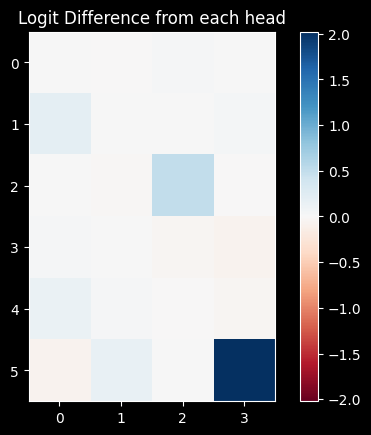

In [178]:
def compute_direct_logit_attribution(
    model: ZanjHookedTransformer,
    cache: ActivationCache,
	answer_tokens: Int[torch.Tensor, "n_mazes"],        
):
    # logit diff
    avg_diff, diff_direction = logit_diff_residual_stream(
        model=model,
        cache=cache,
        answer_tokens=answer_tokens,
        compare_to=None,
        directions=True,
    )

    per_head_residual, labels = cache.stack_head_results(layer=-1, pos_slice=-1, return_labels=True)
    per_head_logit_diffs = residual_stack_to_logit_diff(
        residual_stack=per_head_residual,
        cache=cache,
        logit_diff_directions=diff_direction,
    )
    per_head_logit_diffs = einops.rearrange(
        per_head_logit_diffs, 
        "(layer head_index) -> layer head_index", 
        layer=model.zanj_model_config.model_cfg.n_layers,
        head_index=model.zanj_model_config.model_cfg.n_heads,
    )
    data = per_head_logit_diffs.to("cpu").numpy()
    data_extreme: float = np.max(np.abs(data))
    # colormap centeres on zero
    plt.imshow(data, cmap = "RdBu", vmin=-data_extreme, vmax=data_extreme)
    plt.colorbar()
    plt.title("Logit Difference from each head")
    plt.show()

compute_direct_logit_attribution(
	model=MODEL,
	cache=CACHE,
    answer_tokens=DATASET_TARGET_IDS,
)

# old stuff

In [ ]:
def token_id_find(mazes_tokens, specific_tok):
    '''
    Returns a list of token indexes for a specific token over a batch of mazes.
    '''

    path_start = []
    for maze in mazes_tokens:
        for idx, tok in enumerate(maze):
            if tok == specific_tok:
                path_start.append(idx)
    
    if len(path_start) > mazes_tokens.shape[0]:
        return f'More than one intance of token in one or more mazes'
    else:
        return path_start

def pad_tensor_to_shape(tensor, target_shape, pad_value=10):
    '''
    Used to pad the front of a tokenized maze so examples are all the same length
    '''
    padding = []
    for i in range(len(tensor.shape)-1, -1, -1):
        total_padding = target_shape[i] - tensor.shape[i]
        padding.extend([total_padding, 0])

    return F.pad(tensor, padding, value=pad_value)

# Get a list of the <PATH_START> index for each maze example
path_start = token_id_find(mazes_tokens=mazes_tokens, specific_tok=6)

# Using the <PATH_START> index, strip the tokenized maze of everything after <PATH_START> (so this is the last token)
maze_only_tokens = []
for idx, tok in enumerate(path_start):
    maze_only_tokens.append(mazes_tokens[idx][:tok+1])

# Pad the front of this stripped tokenized maze so that they are all the same length
padded_tokens = []
for maze in maze_only_tokens:
    padded_tokens.append(pad_tensor_to_shape(maze, (166,), 10))

# Make this list of examples into a stacked tensor on the correct device and appropriate dtype
padded_tokens = torch.stack(padded_tokens).long().to(device)

## Model Predictions
Using the model to make predictions and caching associated activations

In [ ]:
# Have the model predict on the maze examples, storing logits and activations in cache
with torch.no_grad():
	logits, cache = MODEL.run_with_cache(padded_tokens)

In [ ]:
# For this architecture, this should of length 208
len(cache.cache_dict.keys())

Logits are in shape [100, 166, 47] corresponding to batch = 100 (100 maze examples), sequence_length = 166 and vocab size = 47.

We want to predict on the next token (the first path coordinate), thus logits associated with final token.

In [ ]:
# Get the last token prediction from the model
last_token_logits = logits[:, -1, :]
predictions = []
for sample in last_token_logits:
    last_token_pred = torch.argmax(sample).item()
    predictions.append(last_token_pred)
predictions = torch.tensor(predictions)
print(f'Prediction from first maze: {predictions[0]}, shape of predictions: {predictions.shape}')

In [ ]:
# Are the maze tokens the same?
print(f'Are all mazes the same in the maze tokens dataset? {padded_tokens.all()}')

## Measuring model performance

**The rest of this notebook is mainly from https://colab.research.google.com/github/neelnanda-io/Easy-Transformer/blob/main/Exploratory_Analysis_Demo.ipynb just applying it to our mazes**

`answer_tokens` is just a list of [correct, incorrect] tokens.

In [ ]:
# Lets create an list of for these predictions in the [correct, incorrect] format.
# The correct token is taken from the maze definition as first token after <PATH_START>, the incorrect token is set to the <TARGET>.

answer_tokens = []
for maze in mazes_tokens:
    for idx, tok in enumerate(maze):
        if tok == 6:
            answer_tokens.append([maze[idx+1], maze[len(maze)-2]])
    
answer_tokens = torch.tensor(answer_tokens).to(device=device)
answer_tokens.shape

It shows us the models performance by comparing the logits associated with a correct response minus those with an incorrect response in this case (1, 0).

In [ ]:
# From Neels explanatory notebook: https://colab.research.google.com/github/neelnanda-io/Easy-Transformer/blob/main/Exploratory_Analysis_Demo.ipynb
def logits_to_ave_logit_diff(logits, answer_tokens, per_prompt=False):
    # Only the final logits are relevant for the answer
    final_logits = logits[:, -1, :]
    answer_logits = final_logits.gather(dim=-1, index=answer_tokens)
    answer_logit_diff = answer_logits[:, 0] - answer_logits[:, 1]
    if per_prompt:
        return answer_logit_diff
    else:
        return answer_logit_diff.mean()

print("Per prompt logit difference:", logits_to_ave_logit_diff(logits, answer_tokens, per_prompt=True))
original_average_logit_diff = logits_to_ave_logit_diff(logits, answer_tokens)
print("Average logit difference:", logits_to_ave_logit_diff(logits, answer_tokens).item())

## Mapping tokens into the model's residual stream

In [ ]:
answer_residual_directions = model.tokens_to_residual_directions(answer_tokens)
print(f"Answer residual directions shape: {answer_residual_directions.shape}")

In [ ]:
logit_diff_directions = answer_residual_directions[:, 0] - answer_residual_directions[:, 1]
print(f"Logit diff directions shape: {logit_diff_directions.shape}")

In [ ]:
# cache the values at the end of the residual stream
final_residual_stream = cache["resid_post", -1]
print(f"Final reisudal stream shape: {final_residual_stream.shape}")

In [ ]:
# Get the final token resid stream values (like we did above with last_pred_token)
final_token_residual_stream = final_residual_stream[:, -1, :]
print(f'Final token residual stream value shape: {final_token_residual_stream.shape}')

In [ ]:
# Scaling the values in residual stream with layer norm
scaled_final_token_residual_stream = cache.apply_ln_to_stack(final_token_residual_stream, layer = -1, pos_slice=-1)

In [ ]:
# Average logit diff from residual stream method
average_logit_diff = einsum("batch d_model, batch d_model -> ", scaled_final_token_residual_stream, logit_diff_directions)/len(answer_tokens)
print("Calculated average logit diff:", average_logit_diff.item())
print("Original logit difference:",original_average_logit_diff.item())

These match quite closely meaning that the residual stream has been correctly scaled.

## Logit Lens

This implementation is directly from Neel's Exploratory Analysis notebook, found here:
https://colab.research.google.com/github/neelnanda-io/Easy-Transformer/blob/main/Exploratory_Analysis_Demo.ipynb

In [ ]:
def residual_stack_to_logit_diff(residual_stack: Float[torch.Tensor, "components batch d_model"], cache: ActivationCache) -> float:
    scaled_residual_stack = cache.apply_ln_to_stack(residual_stack, layer = -1, pos_slice=-1)
    return einsum("... batch d_model, batch d_model -> ...", scaled_residual_stack, logit_diff_directions)/len(answer_tokens)

In [ ]:
accumulated_residual, labels = cache.accumulated_resid(layer=-1, incl_mid=True, pos_slice=-1, return_labels=True)
logit_lens_logit_diffs = residual_stack_to_logit_diff(accumulated_residual, cache)
logit_lens_cpu = logit_lens_logit_diffs.to("cpu")
y = logit_lens_cpu.numpy()
x = np.arange(GPT_CONFIG.n_layers*2+1)/2
print(type(x), type(y))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(x, y)
plt.title("Logit Difference from Accumulated Residual Stream")
plt.show()

In [ ]:
# Layer Attribution
per_layer_residual, labels = cache.decompose_resid(layer=-1, pos_slice=-1, return_labels=True)
per_layer_logit_diffs = residual_stack_to_logit_diff(per_layer_residual, cache)
y = per_layer_logit_diffs.to("cpu").numpy()
x = np.arange(len(y))
print(type(x), type(y))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(x, y)
plt.title("Logit Difference for each layer")
plt.show()

## Direct Logit Attribution
Again from Neel's exploratory analysis notebook.

In [ ]:
per_head_residual, labels = cache.stack_head_results(layer=-1, pos_slice=-1, return_labels=True)
per_head_logit_diffs = residual_stack_to_logit_diff(per_head_residual, cache)
per_head_logit_diffs = einops.rearrange(per_head_logit_diffs, "(layer head_index) -> layer head_index", layer=GPT_CONFIG.n_layers, head_index=GPT_CONFIG.n_heads)
data = per_head_logit_diffs.to("cpu").numpy()
plt.imshow(data, cmap = "RdBu")
plt.colorbar()
plt.title("Logit Difference from each head")
plt.show()